In [1]:
# standard libraries
import importlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import linalg, stats, optimize
import time
import sys
sys.path.append("..")

import pgd
import md_lvm
importlib.reload(pgd)
importlib.reload(md_lvm)

<module 'md_lvm' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/MD_LVM/md_lvm.py'>

In [99]:
# Generate data
D = 3
theta = np.array([2, 3, 4])
sigma = 1
x = theta+np.random.normal(scale = sigma, size = 3)

ndata = 900
f = 2*np.random.uniform(size = (ndata, theta.size))-1
p = 1/(1+np.exp(-np.matmul(f, x)))
y = np.random.binomial(1, p)

In [100]:
y.shape

(900,)

In [101]:
N = 100
K = 6000
gamma = 0.001

th0 = np.array([0, 0, 0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [102]:
th_pgd, X_pgd = pgd.pgd_blr(np.matrix(y).T, f, gamma, K, N, np.matrix(th0).T, X0, sigma)
th_ipla, X_ipla = pgd.ipla_blr(np.matrix(y).T, f, gamma, K, N, np.matrix(th0).T, X0, sigma)
th_md, X_md, W_md = md_lvm.md_toy_bayesian_lr_fast(y, gamma, K, N, th0, X0.T, f, sigma)

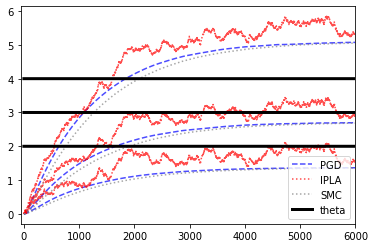

In [106]:
plt.plot(th_pgd[0, :].T, label='PGD', c='blue', linestyle = 'dashed', alpha = 0.7)
plt.plot(th_pgd[1, :].T, label='', c='blue', linestyle = 'dashed', alpha = 0.7)
plt.plot(th_pgd[2, :].T, label='', c='blue', linestyle = 'dashed', alpha = 0.7)
plt.plot(th_ipla[0, :].T, label='IPLA', c='red', linestyle = 'dotted', alpha = 0.7)
plt.plot(th_ipla[1, :].T, label='', c='red', linestyle = 'dotted', alpha = 0.7)
plt.plot(th_ipla[2, :].T, label='', c='red', linestyle = 'dotted', alpha = 0.7)
plt.plot(th_md[:, 0], label='SMC', c='gray', linestyle = 'dotted', alpha = 0.7)
plt.plot(th_md[:, 1], label='', c='gray', linestyle = 'dotted', alpha = 0.7)
plt.plot(th_md[:, 2], label='', c='gray', linestyle = 'dotted', alpha = 0.7)
plt.plot(2*np.ones(K), label='theta', c='black', lw = 3)
plt.plot(3*np.ones(K), label='', c='black', lw = 3)
plt.plot(4*np.ones(K), label='', c='black', lw = 3)
plt.xlim([-K/100, K])
plt.legend(loc='lower right')
# plt.savefig('bayesian_lr_theta.pdf', bbox_inches="tight")

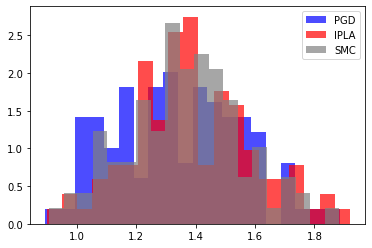

In [104]:
plt.hist(X_pgd[0, -N:].T, density = True, color='blue', alpha = 0.7, label = 'PGD', bins = 20);
plt.hist(X_ipla[0, -N:].T, density = True, color='red', alpha = 0.7, label = 'IPLA', bins = 20);
plt.hist(X_md[K-1, :, 0], weights = W_md, density = True, color='gray', alpha = 0.7, label = 'SMC', bins = 20);
plt.legend(loc='upper right')

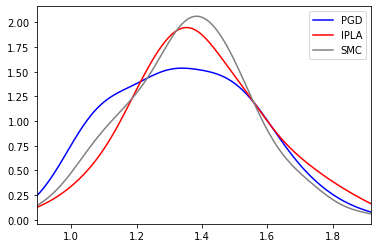

In [107]:
i = 0
kde_min = np.min([X_pgd[i, -N:], X_ipla[i, -N:], np.matrix(X_md[K-1, :, i])])
kde_max = np.max([X_pgd[i, -N:], X_ipla[i, -N:], np.matrix(X_md[K-1, :, i])])
xaxis = np.linspace(kde_min, kde_max, num=100)


kde_pgd = stats.gaussian_kde(X_pgd[i, -N:])(xaxis)
kde_ipla = stats.gaussian_kde(X_ipla[i, -N:])(xaxis)
kde_md = stats.gaussian_kde(X_md[K-1, :, i], weights = W_md)(xaxis)

# Plot KDEs:
plt.plot(xaxis, kde_pgd, label='PGD', color='blue')
plt.plot(xaxis, kde_ipla, label='IPLA', color='red')
plt.plot(xaxis, kde_md, label='SMC', color='gray')
plt.xlim([kde_min, kde_max])
plt.legend(loc='upper right')
# plt.savefig('bayesian_lr_posterior.pdf', bbox_inches="tight")

## Comparison

In [92]:
Nrep = 100
times = np.zeros((Nrep, 3))
estimates = np.zeros((Nrep, D, 3))

In [93]:
K = 6000
gamma = 0.001
N = 100

th0 = np.array([0, 0, 0])  # Initial parameter guess.
X0 = np.random.normal(size = (D, N))  # Initial particle cloud.

In [94]:
for j in range(Nrep):
    start = time.time()
    th_pgd, X_pgd = pgd.pgd_blr(np.matrix(y).T, f, gamma, K, N, np.matrix(th0).T, X0, sigma)
    end = time.time()
    times[j, 0] = end-start
    estimates[j, :, 0] = np.squeeze(np.asarray(th_pgd[:, K-1]))
    start = time.time()
    th_ipla, X_ipla = pgd.ipla_blr(np.matrix(y).T, f, gamma, K, N, np.matrix(th0).T, X0, sigma)
    end = time.time()
    times[j, 1] = end-start
    estimates[j, :, 1] = np.squeeze(np.asarray(th_ipla[:, K-1]))
    start = time.time()
    th_md, X_md, W_md = md_lvm.md_toy_bayesian_lr_fast(y, gamma, K, N, th0, X0.T, f, sigma)
    end = time.time()
    times[j, 2] = end-start
    estimates[j, :, 2] = th_md[K-1, :]

In [95]:
np.mean(times, axis = 0)

array([ 7.47688262,  7.5670006 , 50.69041177])

In [96]:
np.var(estimates, axis = 0)

array([[6.39727836e-06, 8.48039515e-02, 1.97954754e-06],
       [2.58743393e-05, 8.80074182e-02, 2.53520220e-06],
       [1.29220858e-05, 8.64680185e-02, 1.68412152e-06]])

In [97]:
np.mean(times, axis = 0)[2]/np.mean(times, axis = 0)[0]

6.779618505458377